In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [2]:
cd ../data

C:\Users\drewh\Documents\Flatiron Documents\Phase 2\Housing-Sales-Analysis\data


In [3]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Let's see what information we have:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.drop(labels=["sqft_above", "sqft_basement", "yr_renovated", "zipcode", "lat",
                "long","sqft_living15","sqft_lot15"], axis=1, inplace=True)

Now let's look for any outliers throughout the dataset; we'll define some functions for repeated use.

In [6]:
def hist(column):
    return plt.hist(x=df[column])
def hist_rooms(column):
    return plt.hist(x=df[column], bins=np.linspace(1, df[column].max()))
def scat(x):
    y = df["price"]
    x_col = df[x]
    fig, ax = plt.subplots()
    ax.scatter(x=x_col, y=y)
def extreme(column):
    return df.loc[df[column] == df[column].max()]

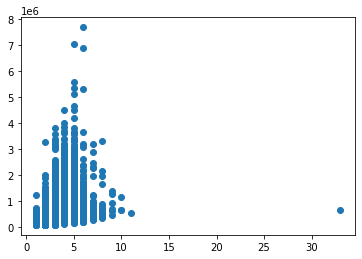

In [7]:
scat("bedrooms")

Yikes, does a house really have over thirty bedrooms bedrooms?

In [8]:
extreme("bedrooms")

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,NO,NONE,Very Good,7 Average,1947


That number of bedrooms doesn't match the square footage; googling the house's ID reveals this house only has three bedrooms. Let's clean up this error.

In [9]:
df["bedrooms"].replace(to_replace=33, value=3, inplace=True)

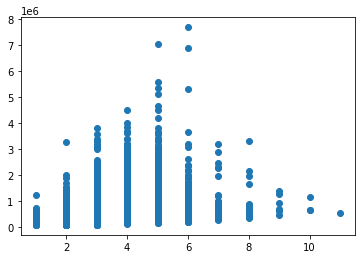

In [10]:
scat("bedrooms")

There's still some suspicious numbers, albeit less egregious. Let's take a look at the 11.

In [11]:
df.loc[df["bedrooms"] == 11]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built
8748,1773100755,8/21/2014,520000.0,11,3.0,3000,4960,2.0,NO,NONE,Average,7 Average,1918


Looking into this house, it appears this house actually has four bedrooms. Let's adjust that.

In [12]:
df["bedrooms"].replace(to_replace=11, value=4, inplace=True)

Much more reasonable - let's repeat the process with the other columns

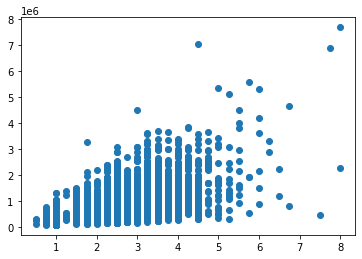

In [13]:
scat("bathrooms")

In [14]:
extreme("bathrooms")

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,NO,GOOD,Good,13 Mansion,1910
12764,1225069038,5/5/2014,2280000.0,7,8.0,13540,307752,3.0,NO,EXCELLENT,Average,12 Luxury,1999


This is lots of bathrooms, but both houses are very large, so they're not unreasonable.

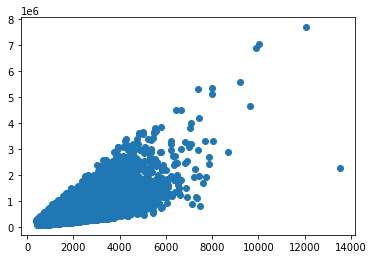

In [15]:
scat("sqft_living")

Since this is a more continuous figure with a number of clear outliers, let's identify and remove them using the IQR.

In [16]:
def drop_outliers(x):
    """Given a column of the dataframe df, drop any outliers from that column
        based on the IQR"""
    q25, q75 = np.percentile(df[x], [25, 75])
    intr_qr = q75-q25
    mx = q75+(1.5*intr_qr)
    mn = q25-(1.5*intr_qr)
    return df[ (df[x]<mx) & (df[x]>mn) ]

In [17]:
def drop_outliers2(x):
    """Given a column of the dataframe df, drop any outliers from that column
        based on z-score"""
    std = df[x].std()
    mx = df[x].mean() + 3*std
    mn = df[x].mean() - 3*std
    return df[ (df[x]<mx) & (df[x]>mn) ]

In [18]:
# df = drop_outliers2("sqft_living")

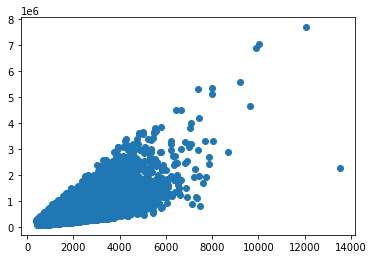

In [19]:
scat("sqft_living")

Much more manageable - while it visually appears that we've cut off quite a bit of data, we've actually only removed about 2.5% of it. Let's take a look at the other metrics:

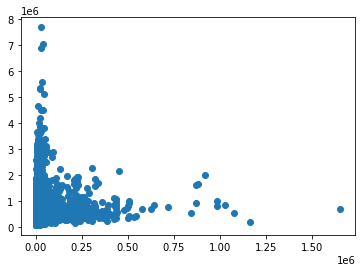

In [20]:
scat("sqft_lot")

This spread is very odd - let's filter out these outliers as well.

In [21]:
# df = drop_outliers2("sqft_lot")

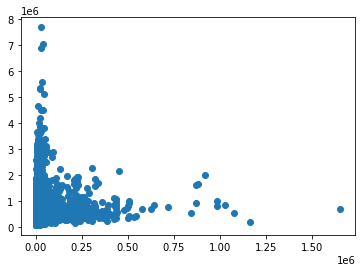

In [22]:
scat("sqft_lot")

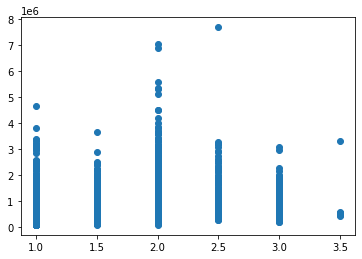

In [23]:
scat("floors")

In [24]:
#We'll do this one a little differently
con = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
con_count = []
for x in con:
    con_count.append(df["condition"].value_counts()[x])

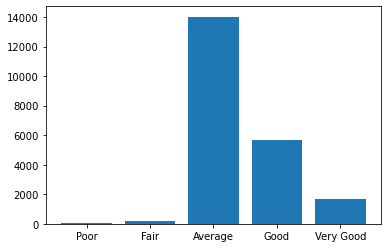

In [25]:
plt.bar(x=con, height=con_count);

In [26]:
# #Repeating the process with grades
grades = ['3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', '9 Better', '10 Very Good',
          '11 Excellent', '12 Luxury', '13 Mansion']
grade_count = []
for x in grades:
    grade_count.append(df["grade"].value_counts()[x])

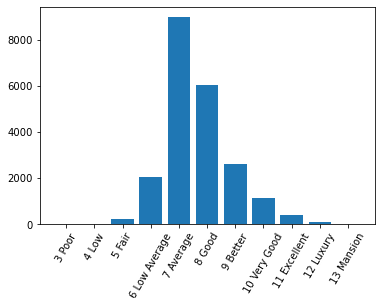

In [27]:
plt.bar(x=grades, height=grade_count)
plt.xticks(rotation = 60);

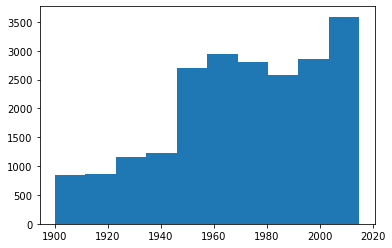

In [28]:
hist("yr_built");

Everything else seems reasonable. With the data cleaned, let's take a closer look.

## Living Area

In [29]:
def simple_model(x):
    y = df["price"]
    x_c = sm.add_constant(x)
    return sm.OLS(endog=y, exog=x_c).fit().summary()

In [30]:
def simple_ylog_model(x):
    y = np.log(df["price"])
    x_c = sm.add_constant(x)
    return sm.OLS(endog=y, exog=x_c).fit().summary()

In [31]:
simple_model(df["sqft_living"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:48   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

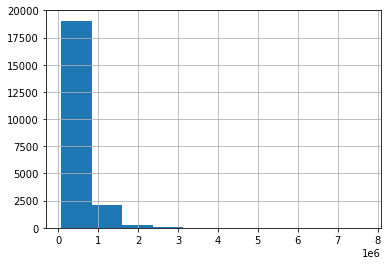

In [32]:
y = df["price"]
y.hist();

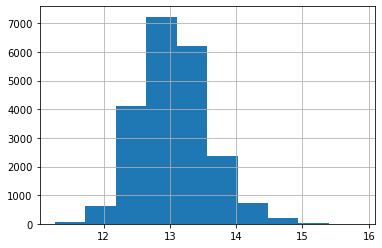

In [33]:
y_log = np.log(y)
y_log.hist();

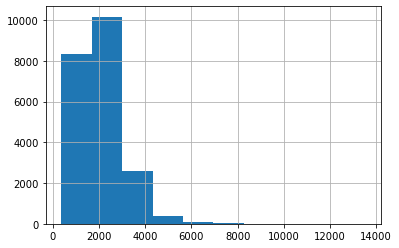

In [34]:
x = df["sqft_living"]
x.hist();

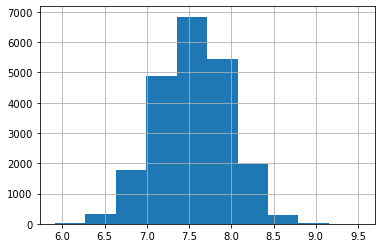

In [35]:
x_log = np.log(x)
x_log.hist();

In [36]:
x_c = sm.add_constant(x)
x_log_c = sm.add_constant(x_log)
sm.OLS(endog=y_log, exog=x_log_c).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:49   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.7234      0.047    142.612      0.000       6.631       6.816
sqft_living     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
sm.OLS(endog=y, exog=x_log_c).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 1.292e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:49   Log-Likelihood:            -3.0233e+05
No. Observations:               21597   AIC:                         6.047e+05
Df Residuals:                   21595   BIC:                         6.047e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.461e+06   3.53e+04    -98.165      0.000   -3.53e+06   -3.39e+06
sqft_living  5.299e+05   4661.551    113.670      0.000    5.21e+05    5.39e+05
==============================================================================
Omnibus:                    19384.826   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1655521.719
Skew:                           3.977   Prob(JB):                         0.00
Kurtosis:                      45.148   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
sm.OLS(endog=y_log, exog=x_c).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 2.020e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:49   Log-Likelihood:                -9662.2
No. Observations:               21597   AIC:                         1.933e+04
Df Residuals:                   21595   BIC:                         1.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2188      0.006   1915.383      0.000      12.206      12.231
sqft_living     0.0004   2.81e-06    142.118      0.000       0.000       0.000
==============================================================================
Omnibus:                        3.541   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.562
Skew:                           0.028   Prob(JB):                        0.169
Kurtosis:                       2.973   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While using the log of either or both values weakens out model's accuracy, the minimalization of the omnibus and JB values is worth achieving. Using the log of the sale price had the greatest impact on these values with the highest r-value, so we'll be sure to take the log of y in our model.

## Lot Square Footage

In [39]:
simple_model(df["sqft_lot"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     175.9
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           5.57e-40
Time:                        18:21:49   Log-Likelihood:            -3.0730e+05
No. Observations:               21597   AIC:                         6.146e+05
Df Residuals:                   21595   BIC:                         6.146e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.283e+05   2650.075    199.337      0.000    5.23e+05    5.33e+05
sqft_lot       0.7973      0.060     13.261      0.000       0.679       0.915
==============================================================================
Omnibus:                    19136.153   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1147708.008
Skew:                           4.030   Prob(JB):                         0.00
Kurtosis:                      37.792   Cond. No.                     4.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
simple_ylog_model(df["sqft_lot"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     218.2
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           3.80e-49
Time:                        18:21:49   Log-Likelihood:                -16683.
No. Observations:               21597   AIC:                         3.337e+04
Df Residuals:                   21595   BIC:                         3.339e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0290      0.004   3433.471      0.000      13.022      13.036
sqft_lot    1.272e-06   8.61e-08     14.773      0.000     1.1e-06    1.44e-06
==============================================================================
Omnibus:                      855.385   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1107.439
Skew:                           0.425   Prob(JB):                    3.33e-241
Kurtosis:                       3.712   Cond. No.                     4.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

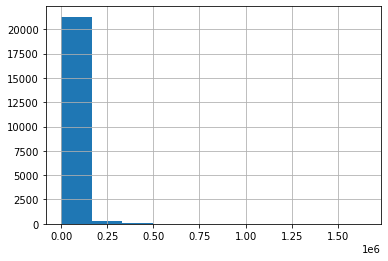

In [41]:
df["sqft_lot"].hist();

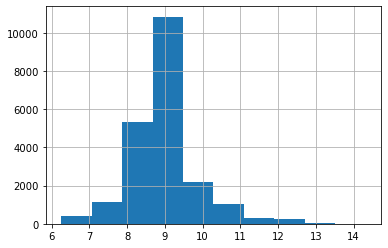

In [42]:
lot_log = np.log(df["sqft_lot"])
lot_log.hist();

In [43]:
lot_log_c = sm.add_constant(lot_log)
simple_model(lot_log_c)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     578.8
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          3.16e-126
Time:                        18:21:50   Log-Likelihood:            -3.0711e+05
No. Observations:               21597   AIC:                         6.142e+05
Df Residuals:                   21595   BIC:                         6.142e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.119e+04   2.47e+04     -2.072      0.038   -9.96e+04   -2757.042
sqft_lot     6.58e+04   2734.876     24.058      0.000    6.04e+04    7.12e+04
==============================================================================
Omnibus:                    18791.266   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1092185.674
Skew:                           3.921   Prob(JB):                         0.00
Kurtosis:                      36.944   Cond. No.                         91.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
simple_ylog_model(lot_log_c)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     420.9
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.21e-92
Time:                        18:21:50   Log-Likelihood:                -16584.
No. Observations:               21597   AIC:                         3.317e+04
Df Residuals:                   21595   BIC:                         3.319e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3227      0.036    346.695      0.000      12.253      12.392
sqft_lot       0.0807      0.004     20.515      0.000       0.073       0.088
==============================================================================
Omnibus:                      621.977   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.236
Skew:                           0.360   Prob(JB):                    5.01e-166
Kurtosis:                       3.572   Cond. No.                         91.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Bedrooms

In [45]:
simple_model(df["bedrooms"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2404.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -3.0625e+05
No. Observations:               21597   AIC:                         6.125e+05
Df Residuals:                   21595   BIC:                         6.125e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.06e+05   9169.706     11.560      0.000     8.8e+04    1.24e+05
bedrooms    1.288e+05   2627.261     49.030      0.000    1.24e+05    1.34e+05
==============================================================================
Omnibus:                    18920.869   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1169042.019
Skew:                           3.942   Prob(JB):                         0.00
Kurtosis:                      38.171   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
simple_ylog_model(df["bedrooms"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     3041.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:                -15369.
No. Observations:               21597   AIC:                         3.074e+04
Df Residuals:                   21595   BIC:                         3.076e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3572      0.013    952.607      0.000      12.332      12.383
bedrooms       0.2050      0.004     55.148      0.000       0.198       0.212
==============================================================================
Omnibus:                      542.645   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              633.359
Skew:                           0.346   Prob(JB):                    2.94e-138
Kurtosis:                       3.474   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Bathrooms

In [47]:
simple_model(df["bathrooms"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     8256.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -3.0389e+05
No. Observations:               21597   AIC:                         6.078e+05
Df Residuals:                   21595   BIC:                         6.078e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8712.6518   6224.769      1.400      0.162   -3488.356    2.09e+04
bathrooms   2.512e+05   2765.054     90.863      0.000    2.46e+05    2.57e+05
==============================================================================
Omnibus:                    17251.570   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           882735.889
Skew:                           3.452   Prob(JB):                         0.00
Kurtosis:                      33.550   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

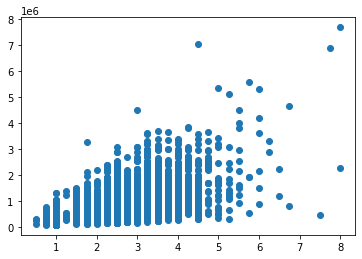

In [48]:
scat("bathrooms")

In [49]:
simple_ylog_model(df["bathrooms"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     9427.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:                -12880.
No. Observations:               21597   AIC:                         2.576e+04
Df Residuals:                   21595   BIC:                         2.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2496      0.009   1399.614      0.000      12.232      12.267
bathrooms      0.3775      0.004     97.092      0.000       0.370       0.385
==============================================================================
Omnibus:                      191.594   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.538
Skew:                           0.232   Prob(JB):                     2.10e-43
Kurtosis:                       3.063   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## View

In [50]:
df["view"].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [51]:
df["view"].isna().sum()

63

In [52]:
view_dummies = pd.get_dummies(df["view"])
view_dummies

,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
21592,0,0,0,0,1
21593,0,0,0,0,1
21594,0,0,0,0,1
21595,0,0,0,0,1


Because we know we have null values in this column, we'll let those serve as our "dropped column" for now.

In [53]:
simple_model(view_dummies)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     853.7
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -3.0544e+05
No. Observations:               21597   AIC:                         6.109e+05
Df Residuals:                   21591   BIC:                         6.109e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.22e+05   4.23e+04     14.705      0.000    5.39e+05    7.05e+05
AVERAGE     1.694e+05   4.37e+04      3.880      0.000    8.38e+04    2.55e+05
EXCELLENT   8.305e+05   4.63e+04     17.934      0.000     7.4e+05    9.21e+05
FAIR        1.914e+05   4.62e+04      4.147      0.000    1.01e+05    2.82e+05
GOOD        3.513e+05   4.48e+04      7.835      0.000    2.63e+05    4.39e+05
NONE       -1.252e+05   4.24e+04     -2.954      0.003   -2.08e+05   -4.21e+04
==============================================================================
Omnibus:                    17920.771   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1069601.442
Skew:                           3.614   Prob(JB):                         0.00
Kurtosis:                      36.710   Cond. No.                         62.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What if we set the nulls as not having a view? As is, it appears that no view is weaker than an undocumented view, but let's take a look. By simply dropping the "none" column, the two will be viewed as equal by the model.

In [54]:
view_dummies2 = view_dummies.drop("NONE", axis=1)

In [55]:
simple_model(view_dummies2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     1065.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -3.0545e+05
No. Observations:               21597   AIC:                         6.109e+05
Df Residuals:                   21592   BIC:                         6.109e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.972e+05   2405.499    206.698      0.000    4.92e+05    5.02e+05
AVERAGE     2.942e+05   1.11e+04     26.461      0.000    2.72e+05    3.16e+05
EXCELLENT   9.553e+05    1.9e+04     50.245      0.000    9.18e+05    9.93e+05
FAIR        3.162e+05   1.86e+04     16.962      0.000     2.8e+05    3.53e+05
GOOD        4.761e+05   1.51e+04     31.547      0.000    4.46e+05    5.06e+05
==============================================================================
Omnibus:                    17955.578   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1079721.400
Skew:                           3.622   Prob(JB):                         0.00
Kurtosis:                      36.873   Cond. No.                         8.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Put these numbers together

In [56]:
def add_views(df):
    df["No_view"] = view_dummies["NONE"]
    df["Fair_view"] = view_dummies["FAIR"]
    df["Average_view"] = view_dummies["AVERAGE"]
    df["Good_view"] = view_dummies["GOOD"]
    df["Excellent_view"] = view_dummies["EXCELLENT"]

In [57]:
drew_data = df.drop(labels=["id","date","price","floors","waterfront","condition","grade","yr_built","view"], axis=1)
add_views(drew_data)
drew_data

,bedrooms,bathrooms,sqft_living,sqft_lot,No_view,Fair_view,Average_view,Good_view,Excellent_view
0,3,1.00,1180,5650,1,0,0,0,0
1,3,2.25,2570,7242,1,0,0,0,0
2,2,1.00,770,10000,1,0,0,0,0
3,4,3.00,1960,5000,1,0,0,0,0
4,3,2.00,1680,8080,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,1,0,0,0,0
21593,4,2.50,2310,5813,1,0,0,0,0
21594,2,0.75,1020,1350,1,0,0,0,0
21595,3,2.50,1600,2388,1,0,0,0,0


In [58]:
x, y = sm.add_constant(drew_data), df["price"]

In [59]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2992.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -2.9865e+05
No. Observations:               21597   AIC:                         5.973e+05
Df Residuals:                   21587   BIC:                         5.974e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.487e+05   3.16e+04      4.708      0.000    8.68e+04    2.11e+05
bedrooms       -5.415e+04   2344.088    -23.100      0.000   -5.87e+04   -4.96e+04
bathrooms        1.15e+04   3357.267      3.427      0.001    4924.386    1.81e+04
sqft_living      285.0403      3.101     91.922      0.000     278.962     291.118
sqft_lot          -0.3848      0.041     -9.347      0.000      -0.465      -0.304
No_view        -5.864e+04   3.09e+04     -1.896      0.058   -1.19e+05    1992.982
Fair_view       1.011e+05   3.37e+04      2.998      0.003     3.5e+04    1.67e+05
Average_view    6.098e+04   3.19e+04      1.912      0.056   -1525.293    1.23e+05
Good_view       1.462e+05   3.28e+04      4.459      0.000    8.19e+04     2.1e+05
Excellent_view  5.259e+05   3.39e+04     15.517      0.000    4.59e+05    5.92e+05
==============================================================================
Omnibus:                    13564.946   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           496364.594
Skew:                           2.469   Prob(JB):                         0.00
Kurtosis:                      25.961   Cond. No.                     2.02e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's see if using the log of y will improve our model.

In [60]:
y_log = np.log(y)
sm.OLS(y_log, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2563.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:                -8943.1
No. Observations:               21597   AIC:                         1.791e+04
Df Residuals:                   21587   BIC:                         1.799e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.3325      0.047    261.363      0.000      12.240      12.425
bedrooms          -0.0503      0.004    -14.360      0.000      -0.057      -0.043
bathrooms          0.0581      0.005     11.574      0.000       0.048       0.068
sqft_living        0.0004   4.63e-06     79.413      0.000       0.000       0.000
sqft_lot       -3.302e-07   6.15e-08     -5.369      0.000   -4.51e-07    -2.1e-07
No_view           -0.0241      0.046     -0.522      0.602      -0.115       0.066
Fair_view          0.2282      0.050      4.531      0.000       0.129       0.327
Average_view       0.1742      0.048      3.657      0.000       0.081       0.268
Good_view          0.2329      0.049      4.756      0.000       0.137       0.329
Excellent_view     0.4833      0.051      9.545      0.000       0.384       0.583
==============================================================================
Omnibus:                       12.548   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.165
Skew:                          -0.036   Prob(JB):                      0.00138
Kurtosis:                       3.097   Cond. No.                     2.02e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While the bathrooms showed a stronger correlation with the log of the price, the other factors prevented this from being the best overall choice. Now, let's address the multicolinearity. 

Let's scale this data before diving into the multicolinearity.

In [61]:
x_nums = drew_data.drop(labels=["No_view", "Fair_view", "Average_view", "Good_view", "Excellent_view"], axis=1)

In [62]:
x_scaled = StandardScaler().fit_transform(x_nums.values)
x_scaled_df = pd.DataFrame(x_scaled, index=x_nums.index, columns=x_nums.columns)
x_c = sm.add_constant(x_scaled_df)

In [63]:
sm.OLS(y, x_c).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     5623.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -2.9968e+05
No. Observations:               21597   AIC:                         5.994e+05
Df Residuals:                   21592   BIC:                         5.994e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.403e+05   1749.651    308.803      0.000    5.37e+05    5.44e+05
bedrooms    -5.931e+04   2206.541    -26.878      0.000   -6.36e+04    -5.5e+04
bathrooms    5485.1930   2706.747      2.026      0.043     179.768    1.08e+04
sqft_living  2.917e+05   2899.562    100.606      0.000    2.86e+05    2.97e+05
sqft_lot    -1.606e+04   1785.994     -8.995      0.000   -1.96e+04   -1.26e+04
==============================================================================
Omnibus:                    14205.165   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           468271.599
Skew:                           2.685   Prob(JB):                         0.00
Kurtosis:                      25.171   Cond. No.                         3.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that our condition number is minimal, if it reappears with the view columns, we'll know they're to blame. Let's add them in now!

In [64]:
add_views(x_c)

In [65]:
sm.OLS(y, x_c).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2992.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:50   Log-Likelihood:            -2.9865e+05
No. Observations:               21597   AIC:                         5.973e+05
Df Residuals:                   21587   BIC:                         5.974e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.776e+05   3.09e+04     18.704      0.000    5.17e+05    6.38e+05
bedrooms       -4.887e+04   2115.760    -23.100      0.000    -5.3e+04   -4.47e+04
bathrooms       8846.8657   2581.626      3.427      0.001    3786.688    1.39e+04
sqft_living     2.617e+05   2846.874     91.922      0.000    2.56e+05    2.67e+05
sqft_lot       -1.593e+04   1704.861     -9.347      0.000   -1.93e+04   -1.26e+04
No_view        -5.864e+04   3.09e+04     -1.896      0.058   -1.19e+05    1992.982
Fair_view       1.011e+05   3.37e+04      2.998      0.003     3.5e+04    1.67e+05
Average_view    6.098e+04   3.19e+04      1.912      0.056   -1525.293    1.23e+05
Good_view       1.462e+05   3.28e+04      4.459      0.000    8.19e+04     2.1e+05
Excellent_view  5.259e+05   3.39e+04     15.517      0.000    4.59e+05    5.92e+05
==============================================================================
Omnibus:                    13564.946   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           496364.594
Skew:                           2.469   Prob(JB):                         0.00
Kurtosis:                      25.961   Cond. No.                         69.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have some high p-values in the view column; let's try dropping the column for no view and see if it improves the model.

In [66]:
x_c2 = x_c.drop("No_view", axis=1)

In [67]:
sm.OLS(y, x_c2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     3365.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:51   Log-Likelihood:            -2.9865e+05
No. Observations:               21597   AIC:                         5.973e+05
Df Residuals:                   21588   BIC:                         5.974e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.192e+05   1763.802    294.354      0.000    5.16e+05    5.23e+05
bedrooms       -4.889e+04   2115.870    -23.107      0.000    -5.3e+04   -4.47e+04
bathrooms       8810.5492   2581.710      3.413      0.001    3750.207    1.39e+04
sqft_living     2.618e+05   2846.672     91.959      0.000    2.56e+05    2.67e+05
sqft_lot       -1.593e+04   1704.960     -9.342      0.000   -1.93e+04   -1.26e+04
Fair_view       1.595e+05   1.37e+04     11.673      0.000    1.33e+05    1.86e+05
Average_view    1.194e+05   8221.302     14.523      0.000    1.03e+05    1.36e+05
Good_view       2.046e+05   1.12e+04     18.239      0.000    1.83e+05    2.27e+05
Excellent_view  5.843e+05   1.42e+04     41.241      0.000    5.56e+05    6.12e+05
==============================================================================
Omnibus:                    13588.727   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           500182.192
Skew:                           2.474   Prob(JB):                         0.00
Kurtosis:                      26.051   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see no change to adj. r-squared, and the high p-values are gone; let's go ahead and continue leaving out this column.

In [68]:
sm.OLS(y_log, x_c2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2883.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:51   Log-Likelihood:                -8943.2
No. Observations:               21597   AIC:                         1.790e+04
Df Residuals:                   21588   BIC:                         1.798e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.0221      0.003   4942.220      0.000      13.017      13.027
bedrooms          -0.0454      0.003    -14.363      0.000      -0.052      -0.039
bathrooms          0.0446      0.004     11.571      0.000       0.037       0.052
sqft_living        0.3378      0.004     79.434      0.000       0.329       0.346
sqft_lot          -0.0137      0.003     -5.368      0.000      -0.019      -0.009
Fair_view          0.2522      0.020     12.360      0.000       0.212       0.292
Average_view       0.1983      0.012     16.144      0.000       0.174       0.222
Good_view          0.2569      0.017     15.335      0.000       0.224       0.290
Excellent_view     0.5073      0.021     23.972      0.000       0.466       0.549
==============================================================================
Omnibus:                       12.514   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.127
Skew:                          -0.036   Prob(JB):                      0.00141
Kurtosis:                       3.097   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking Assumptions

In [69]:
model = sm.OLS(y_log, x_c2).fit()

In [70]:
model.summary().tables[2]

Omnibus:,12.514,Durbin-Watson:,1.972
Prob(Omnibus):,0.002,Jarque-Bera (JB):,13.127
Skew:,-0.036,Prob(JB):,0.00141
Kurtosis:,3.097,Cond. No.,13.0


In [71]:
model_preds = model.predict(x_c2)
resids = y_log - model_preds

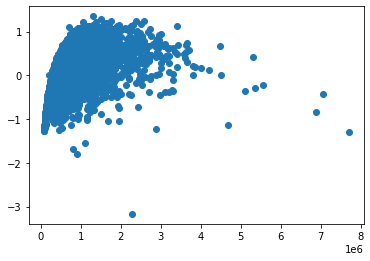

In [72]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

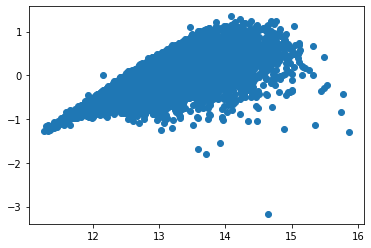

In [73]:
model2 = sm.OLS(endog=y_log, exog=x_c2).fit()
model2_preds = model2.predict(x_c2)
model2_resid = y_log - model2_preds

fig, ax = plt.subplots()
ax.scatter(y_log, model2_resid);

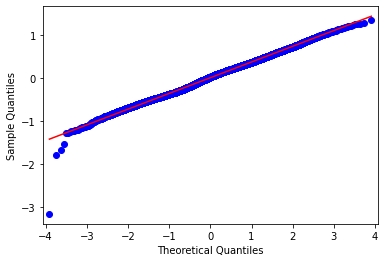

In [74]:
sm.qqplot(model2_resid, line='r');

## Combine

In [75]:
df2 = df.drop(labels=["id","date","price","bedrooms","bathrooms","sqft_living","sqft_lot","view"],axis=1)

In [76]:
dummy_df = pd.get_dummies(df2)

In [77]:
dummy_df.drop(labels=["waterfront_NO","condition_Average","grade_7 Average"],axis=1,inplace=True)

In [78]:
x_c_comb = dummy_df.join(x_c2)

In [79]:
sm.OLS(y_log, x_c_comb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     1614.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:51   Log-Likelihood:                -5403.8
No. Observations:               21597   AIC:                         1.086e+04
Df Residuals:                   21571   BIC:                         1.107e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
floors                  0.0773      0.005     15.447      0.000       0.067       0.087
yr_built               -0.0058   9.78e-05    -59.208      0.000      -0.006      -0.006
waterfront_YES          0.3144      0.032      9.976      0.000       0.253       0.376
condition_Fair         -0.1680      0.024     -6.919      0.000      -0.216      -0.120
condition_Good          0.0188      0.005      3.578      0.000       0.009       0.029
condition_Poor         -0.1484      0.058     -2.547      0.011      -0.263      -0.034
condition_Very Good     0.0853      0.008     10.057      0.000       0.069       0.102
grade_10 Very Good      0.6275      0.012     50.310      0.000       0.603       0.652
grade_11 Excellent      0.7452      0.019     38.377      0.000       0.707       0.783
grade_12 Luxury         0.8355      0.037     22.783      0.000       0.764       0.907
grade_13 Mansion        0.8479      0.090      9.470      0.000       0.672       1.023
grade_3 Poor           -0.4284      0.311     -1.377      0.169      -1.038       0.181
grade_4 Low            -0.5837      0.060     -9.681      0.000      -0.702      -0.465
grade_5 Fair           -0.4975      0.021    -23.986      0.000      -0.538      -0.457
grade_6 Low Average    -0.2793      0.008    -34.420      0.000      -0.295      -0.263
grade_8 Good            0.2359      0.006     40.382      0.000       0.224       0.247
grade_9 Better          0.4687      0.009     53.857      0.000       0.452       0.486
const                  24.1774      0.192    126.034      0.000      23.801      24.553
bedrooms               -0.0304      0.003    -10.781      0.000      -0.036      -0.025
bathrooms               0.0620      0.004     16.187      0.000       0.054       0.069
sqft_living             0.1699      0.005     37.376      0.000       0.161       0.179
sqft_lot               -0.0015      0.002     -0.670      0.503      -0.006       0.003
Fair_view               0.1802      0.017     10.353      0.000       0.146       0.214
Average_view            0.0968      0.011      9.190      0.000       0.076       0.117
Good_view               0.1319      0.014      9.188      0.000       0.104       0.160
Excellent_view          0.2623      0.022     12.009      0.000       0.219       0.305
==============================================================================
Omnibus:                      104.042   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.898
Skew:                          -0.101   Prob(JB):                     4.59e-28
Kurtosis:                       3.315   Cond. No.                     2.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

The high conditional number isn't ideal - let's see if we can identify what's causing it by dropping a suspicious column. Year built is the most continuous variable that hasn't been scaled, so let's try dropping it as a test.

In [80]:
test = x_c_comb.drop(labels="yr_built",axis=1)

In [81]:
sm.OLS(y_log, test).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1321.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:52   Log-Likelihood:                -7029.9
No. Observations:               21597   AIC:                         1.411e+04
Df Residuals:                   21572   BIC:                         1.431e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
floors                  0.0228      0.005      4.301      0.000       0.012       0.033
waterfront_YES          0.3393      0.034      9.986      0.000       0.273       0.406
condition_Fair         -0.1059      0.026     -4.049      0.000      -0.157      -0.055
condition_Good          0.0820      0.006     14.763      0.000       0.071       0.093
condition_Poor         -0.0283      0.063     -0.450      0.653      -0.151       0.095
condition_Very Good     0.2201      0.009     24.985      0.000       0.203       0.237
grade_10 Very Good      0.5568      0.013     41.593      0.000       0.531       0.583
grade_11 Excellent      0.6714      0.021     32.135      0.000       0.630       0.712
grade_12 Luxury         0.7628      0.040     19.303      0.000       0.685       0.840
grade_13 Mansion        0.8906      0.097      9.226      0.000       0.701       1.080
grade_3 Poor           -0.3206      0.335     -0.956      0.339      -0.978       0.337
grade_4 Low            -0.4758      0.065     -7.323      0.000      -0.603      -0.348
grade_5 Fair           -0.3916      0.022    -17.575      0.000      -0.435      -0.348
grade_6 Low Average    -0.2030      0.009    -23.503      0.000      -0.220      -0.186
grade_8 Good            0.1927      0.006     30.834      0.000       0.180       0.205
grade_9 Better          0.3953      0.009     42.556      0.000       0.377       0.413
const                  12.8298      0.009   1451.082      0.000      12.812      12.847
bedrooms               -0.0182      0.003     -5.990      0.000      -0.024      -0.012
bathrooms              -0.0055      0.004     -1.392      0.164      -0.013       0.002
sqft_living             0.1964      0.005     40.283      0.000       0.187       0.206
sqft_lot               -0.0082      0.002     -3.498      0.000      -0.013      -0.004
Fair_view               0.2413      0.019     12.881      0.000       0.205       0.278
Average_view            0.1651      0.011     14.630      0.000       0.143       0.187
Good_view               0.2107      0.015     13.669      0.000       0.180       0.241
Excellent_view          0.3359      0.024     14.287      0.000       0.290       0.382
==============================================================================
Omnibus:                        7.075   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.968
Skew:                           0.033   Prob(JB):                       0.0307
Kurtosis:                       2.941   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That dropped our conditional number dramatically! Let's scale the year built column and add it back in.

In [82]:
yr_scaled = (x_c_comb["yr_built"] - np.mean(x_c_comb["yr_built"])) / np.std(x_c_comb["yr_built"])
yr_scaled_df = pd.DataFrame(yr_scaled, index=x_c_comb["yr_built"].index)

In [83]:
x_c_comb2 = test.merge(yr_scaled_df,left_index=True, right_index=True)

In [84]:
sm.OLS(y_log, x_c_comb2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     1614.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:21:52   Log-Likelihood:                -5403.8
No. Observations:               21597   AIC:                         1.086e+04
Df Residuals:                   21571   BIC:                         1.107e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
floors                  0.0773      0.005     15.447      0.000       0.067       0.087
waterfront_YES          0.3144      0.032      9.976      0.000       0.253       0.376
condition_Fair         -0.1680      0.024     -6.919      0.000      -0.216      -0.120
condition_Good          0.0188      0.005      3.578      0.000       0.009       0.029
condition_Poor         -0.1484      0.058     -2.547      0.011      -0.263      -0.034
condition_Very Good     0.0853      0.008     10.057      0.000       0.069       0.102
grade_10 Very Good      0.6275      0.012     50.310      0.000       0.603       0.652
grade_11 Excellent      0.7452      0.019     38.377      0.000       0.707       0.783
grade_12 Luxury         0.8355      0.037     22.783      0.000       0.764       0.907
grade_13 Mansion        0.8479      0.090      9.470      0.000       0.672       1.023
grade_3 Poor           -0.4284      0.311     -1.377      0.169      -1.038       0.181
grade_4 Low            -0.5837      0.060     -9.681      0.000      -0.702      -0.465
grade_5 Fair           -0.4975      0.021    -23.986      0.000      -0.538      -0.457
grade_6 Low Average    -0.2793      0.008    -34.420      0.000      -0.295      -0.263
grade_8 Good            0.2359      0.006     40.382      0.000       0.224       0.247
grade_9 Better          0.4687      0.009     53.857      0.000       0.452       0.486
const                  12.7655      0.008   1543.202      0.000      12.749      12.782
bedrooms               -0.0304      0.003    -10.781      0.000      -0.036      -0.025
bathrooms               0.0620      0.004     16.187      0.000       0.054       0.069
sqft_living             0.1699      0.005     37.376      0.000       0.161       0.179
sqft_lot               -0.0015      0.002     -0.670      0.503      -0.006       0.003
Fair_view               0.1802      0.017     10.353      0.000       0.146       0.214
Average_view            0.0968      0.011      9.190      0.000       0.076       0.117
Good_view               0.1319      0.014      9.188      0.000       0.104       0.160
Excellent_view          0.2623      0.022     12.009      0.000       0.219       0.305
yr_built               -0.1701      0.003    -59.208      0.000      -0.176      -0.164
==============================================================================
Omnibus:                      104.042   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.898
Skew:                          -0.101   Prob(JB):                     4.59e-28
Kurtosis:                       3.315   Cond. No.                         284.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

In [85]:
print(f"Square Foot of Living Space std: {df['sqft_living'].std()}")
print(f"Square Foot of Lot std: {df['sqft_lot'].std()}")
print(f"Year built std: {df['yr_built'].std()}")
print(f"Bedroom std: {df['bedrooms'].std()}")
print(f"Bathroom std: {df['bathrooms'].std()}")

Square Foot of Living Space std: 918.1061250800805
Square Foot of Lot std: 41412.636875502074
Year built std: 29.375234132441644
Bedroom std: 0.9026150387107811
Bathroom std: 0.7689842966527209


Adding a floor ups the price by 7.7%

Being waterfront increases the price by 31%

Adding a 3/4 bathroom increases price by 6%

Adding 918 square feet increases price by 17%

Having a view can increase the price from 18 to 26%

A home in poor condition can be nearly 15% cheaper, while a very good home can be 8% more expensive

Construction quality has a massive impact; below-average homes sell 25 to 60% cheaper than average homes, while more luxury homes sell for as much as 85% more

Year built, square footage of the lot, and number of bedrooms do not have significant impacts.